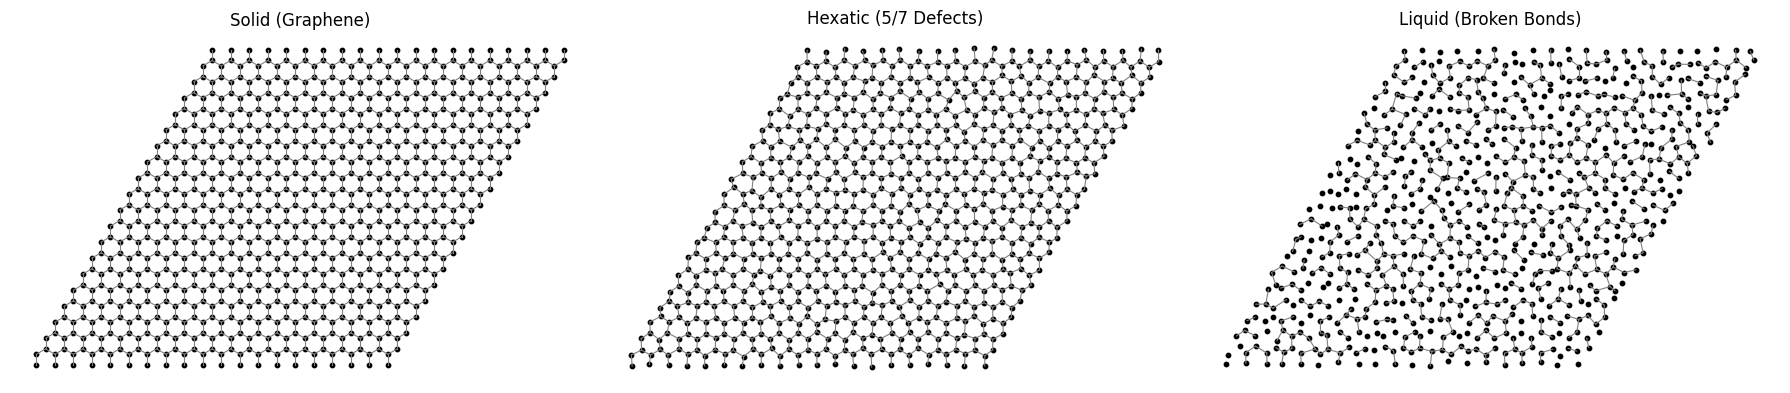

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import random

# Parameters
nx, ny = 20, 20       # number of unit cells in x and y
a = 1.42             # C-C bond length (Å)
bond_cutoff = 1.2 * a  # neighbor distance cutoff


def generate_graphene(nx, ny, a):
    """Generate perfect graphene coordinates in a rectangular cell."""
    coords = []
    # basis vectors for hexagonal lattice
    vec_a = np.array([np.sqrt(3)*a, 0])
    vec_b = np.array([np.sqrt(3)/2*a, 3/2*a])
    # two atoms per unit cell
    basis = [np.array([0,0]), np.array([0, a])]
    for i in range(nx):
        for j in range(ny):
            origin = i*vec_a + j*vec_b
            for b in basis:
                coords.append(origin + b)
    return np.array(coords)


def build_bonds(coords, cutoff):
    """Use KDTree to find neighbor bonds below cutoff."""
    tree = KDTree(coords)
    pairs = tree.query_pairs(r=cutoff)
    return list(pairs)


def stone_wales(coords, bonds, n_sw=10):
    """Introduce Stone-Wales (5-7) defects by rotating random bonds."""
    new_bonds = set(bonds)
    for _ in range(n_sw):
        # pick a random bond
        i,j = random.choice(list(new_bonds))
        # find two common neighbors for rotation
        # find neighbors of i and j
        neigh_i = {k for (i1,k) in new_bonds if i1==i} | {i1 for (i1,k) in new_bonds if k==i}
        neigh_j = {k for (j1,k) in new_bonds if j1==j} | {j1 for (j1,k) in new_bonds if k==j}
        common = neigh_i & neigh_j
        if len(common)!=2:
            continue
        k,l = list(common)
        # remove old two bonds
        new_bonds.remove((i,j) if (i,j) in new_bonds else (j,i))
        # remove bonds to common neighbors
        for pair in [(i,k),(i,l),(j,k),(j,l)]:
            if tuple(pair) in new_bonds: new_bonds.remove(tuple(pair))
            elif tuple(pair[::-1]) in new_bonds: new_bonds.remove(tuple(pair[::-1]))
        # add rotated bonds
        new_bonds.add(tuple(sorted((i,k))))
        new_bonds.add(tuple(sorted((j,l))))
        new_bonds.add(tuple(sorted((i,l))))
        new_bonds.add(tuple(sorted((j,k))))
    return list(new_bonds)

# Generate solid
solid_coords = generate_graphene(nx, ny, a)
solid_bonds = build_bonds(solid_coords, bond_cutoff)

# Hexatic: apply SW defects and slight random displacements
hex_coords = solid_coords + np.random.normal(scale=0.1, size=solid_coords.shape)
hex_bonds = stone_wales(hex_coords, solid_bonds, n_sw=100)

# Liquid: remove random bonds and larger displacement
liquid_coords = solid_coords + np.random.normal(scale=0.2, size=solid_coords.shape)
liquid_bonds = random.sample(solid_bonds, k=int(0.5*len(solid_bonds)))

# Save coordinates
np.savetxt('solid_coords.txt', solid_coords, fmt='%.6f', header='x y')
np.savetxt('hexatic_coords.txt', hex_coords, fmt='%.6f', header='x y')
np.savetxt('liquid_coords.txt', liquid_coords, fmt='%.6f', header='x y')

# Plotting
def plot_phase(coords, bonds, ax, title):
    for i,j in bonds:
        x = [coords[i,0], coords[j,0]]
        y = [coords[i,1], coords[j,1]]
        ax.plot(x, y, color='gray', linewidth=0.8)
    ax.scatter(coords[:,0], coords[:,1], color='black', s=10)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.axis('off')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_phase(solid_coords, solid_bonds, axes[0], 'Solid (Graphene)')
plot_phase(hex_coords, hex_bonds, axes[1], 'Hexatic (5/7 Defects)')
plot_phase(liquid_coords, liquid_bonds, axes[2], 'Liquid (Broken Bonds)')
plt.tight_layout()
plt.show()
